Testing the analytic lhf with jake's prior

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import emcee

Define prior, log prob and log like

In [14]:
def lnprior(pars):
    m, b, s = pars
    if s < 0:
        return -np.inf
    else:
        return -1.5 * np.log(1 + b ** 2) - np.log(s)

In [15]:
def lnprob(pars, x, y, xerr, yerr):
    return lnprior(pars) + lnlike(pars, x, y, xerr, yerr)

In [16]:
def lnlike(pars, x, y, xerr, yerr):
    m, b, s = pars
    sig2 = (m*xerr)**2 + (yerr**2 + s**2)
    ll = -.5 * np.sum((m*x-y+b)**2/sig2 + np.log(sig2))
    return ll

Load and plot the data

params =  -0.525509606298 1.31256220367


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


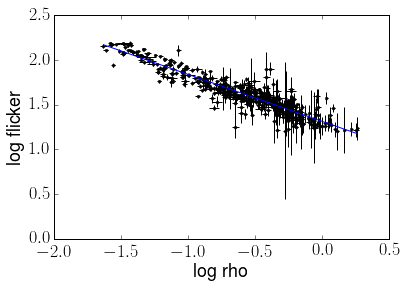

In [17]:
# load data
f, ferr, r, rerr = np.genfromtxt("../data/flickers.dat").T
r -= 3  # convert rho to g/cm^3

# fit a line
AT = np.vstack((r, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(r), max(r), 100)
ys = m * xs + c
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log rho")

In [18]:
pars_init = [m, c, 0.06]
print(lnlike(pars_init, r, f, rerr, ferr)) # check the lhf works

875.180570019


In [19]:
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(r, f, rerr, ferr))
sampler.run_mcmc(pos, 20000)  # run MCMC
samples = sampler.chain[:, 19000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
m2, c2, sig2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

In [9]:
# save samples
import h5py
fi = h5py.File("rho_samples.h5", "w")
data = fi.create_dataset("samples", np.shape(sampler.chain))
data[:, :] = np.array(sampler.chain)
fi.close()

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


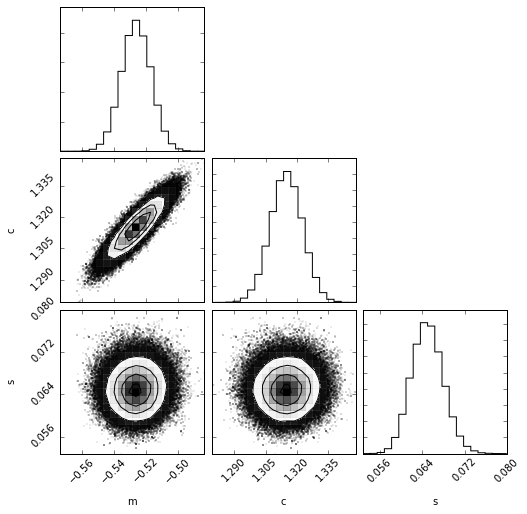

In [10]:
fig = corner.corner(samples, labels=["m", "c", "s"])

Make figure for paper

In [11]:
plotpar = {'axes.labelsize': 18,
           'text.fontsize': 14,
           'legend.fontsize': 18,
           'xtick.labelsize': 18,
           'ytick.labelsize': 18,
           'text.usetex': True}
plt.rcParams.update(plotpar)

pink = "#FF33CC"
blue = "#0066CC"

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:855: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [12]:
alpha, ap, am = c2
beta, bp, bm = m2
sigma, sp, sm = sig2
ys = m2[0] * xs + c2[0]
resids = f - m2[0] * r + c2[0]
plt.fill_between(xs, ys-2*np.std(resids)-2*sig2[0], ys+2*np.std(resids)+2*sig2[0], color=pink, alpha=.1)
plt.fill_between(xs, ys-np.std(resids)-sig2[0], ys+np.std(resids)+sig2[0], color=pink, alpha=.3)
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0, ecolor=".5", mec=".2", alpha=.5)
plt.plot(xs, ys, "k")
plt.plot(xs, ys-np.std(resids), color=pink)
plt.plot(xs, ys+np.std(resids), color=pink)
plt.ylabel("$\log_{10}(F_8)$")
plt.xlabel("$\log_{10}(\\rho_{\star}[\mathrm{g~cm}^{-3}])$")
#plt.text(-1.15, 2.25, "$\log_{10} (\\rho_{\star}) \sim \mathcal{N} \left(\\alpha_\\rho + \\beta_\\rho \log_{10}(F_8), \
#                \\sigma=\\sigma_{\\rho}\\right)$")
plt.text(-1.15, 2.25, "$\log_{10} (F_8) \sim \mathcal{N} \left(\\alpha_\\rho + \\beta_\\rho \log_{10}(\\rho_{\star}), \
                \\sigma=\\sigma_{\\rho}\\right)$")
plt.text(-1.45, 1.2, "$\\alpha_\\rho = %.2f \pm %.2f$" % (np.round(alpha, 2), np.round(ap, 2)))
plt.text(-1.45, 1., "$\\beta_\\rho = %.2f \pm %.2f $" % (np.round(beta, 2), np.round(bp, 2)))
plt.text(-1.45, .8, "$\\sigma_{\\rho} = %.3f \pm %.3f $" % (np.round(sigma, 2), np.round(sp, 3)))
plt.xlim(min(r), max(r))
plt.ylim(.4, 2.5)
plt.savefig("../version1.0/flicker_vs_rho.pdf")

TypeError: unsupported operand type(s) for -: 'File' and 'float'

Now with flicker vs logg

params =  -0.826618949099 4.90659568177


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


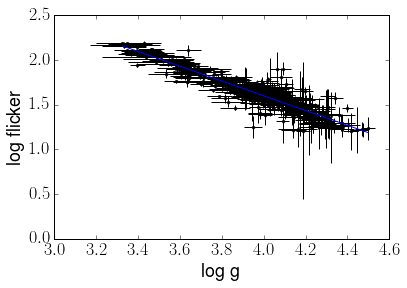

In [98]:
# load data
f, ferr, l, lerr, _, _ = np.genfromtxt("../data/log.dat").T

# fit a line
AT = np.vstack((l, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print("params = ", m, c)

# plot data with best fit line
xs = np.linspace(min(l), max(l), 100)
ys = m * xs + c
plt.errorbar(l, f, xerr=lerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log g")

In [99]:
pars_init = [m, c, 0.06]
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]  # initialisation
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(l, f, rerr, ferr))
sampler.run_mcmc(pos, 20000)  # run MCMC
samples = sampler.chain[:, 19000:, :].reshape((-1, ndim))  # cut off burn in and flatten chains
m2, c2, sig2 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


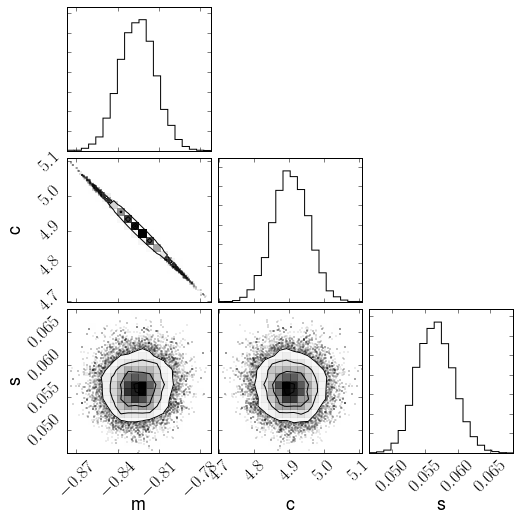

In [100]:
fig = corner.corner(samples, labels=["m", "c", "s"])

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


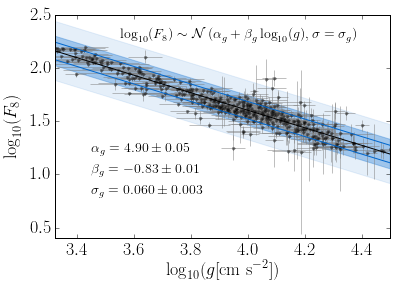

In [101]:
alpha, ap, am = c2
beta, bp, bm = m2
sigma, sp, sm = sig2
ys = m2[0] * xs + c2[0]
resids = f - m2[0] * l + c2[0]
plt.fill_between(xs, ys-2*np.std(resids)-2*sig2[0], ys+2*np.std(resids)+2*sig2[0], color=blue, alpha=.1)
plt.fill_between(xs, ys-np.std(resids)-sig2[0], ys+np.std(resids)+sig2[0], color=blue, alpha=.3)
plt.errorbar(l, f, xerr=lerr, yerr=ferr, fmt="k.", capsize=0, ecolor=".5", mec=".2", alpha=.5)
plt.plot(xs, ys, "k")
plt.plot(xs, ys-np.std(resids), color=blue)
plt.plot(xs, ys+np.std(resids), color=blue)
plt.ylabel("$\log_{10}(F_8)$")
plt.xlabel("$\log_{10}(g [\mathrm{cm~s}^{-2}])$")
plt.text(3.55, 2.25, "$\log_{10} (F_8) \sim \mathcal{N} \left(\\alpha_g + \\beta_g \log_{10}(g), \
                \\sigma=\\sigma_g\\right)$")
plt.text(3.45, 1.2, "$\\alpha_g = %.2f \pm %.2f$" % (np.round(alpha, 2), np.round(ap, 2)))
plt.text(3.45, 1., "$\\beta_g = %.2f \pm %.2f $" % (np.round(beta, 2), np.round(bp, 2)))
plt.text(3.45, .8, "$\\sigma_g = %.3f \pm %.3f $" % (np.round(sigma, 2), np.round(sp, 3)))
plt.xlim(min(l), max(l))
plt.ylim(.4, 2.5)
plt.savefig("../version1.0/flicker_vs_logg.pdf")

In [ ]:
# save samples
fi = h5py.File("logg_samples.h5", "w")
data = fi.create_dataset("samples", np.shape(sampler.chain))
data[:, :] = np.array(sampler.chain)
fi.close()